In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import gc

torch.cuda.empty_cache()
gc.collect()

11

In [2]:
! ls 'drive/My Drive/NLP/팀플/study'

data_check.ipynb      gtp2.ipynb		   train.csv
gpt2_embedding.ipynb  preprocessed_train_data.csv  train_filtered.csv


In [3]:
# hugging face install
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 59 kB 6.1 MB/s 
     |████████████████████████████████| 596 kB 47.4 MB/s 
     |████████████████████████████████| 3.3 MB 34.3 MB/s 
     |████████████████████████████████| 895 kB 32.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
import io
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification,
                          GPT2LMHeadModel)

In [5]:
import tqdm 

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

import shutil

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')

Running on device: cuda:0


**DATA 전처리**

In [6]:
path = 'drive/My Drive/NLP/팀플/study/train_filtered.csv'

In [ ]:
## try balanced_case

In [7]:
data = pd.read_csv(path)

# 중복 데이터 제거
data.drop_duplicates('Lyrics')

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...
...,...,...,...,...,...
249943,bobby womack,i wish he didn t trust me so much,R&B,en,I'm the best friend he's got I'd give him the ...
249944,bad boys blue,i totally miss you,Pop,en,"Bad Boys Blue ""I Totally Miss You"" I did you w..."
249945,celine dion,sorry for love,Pop,en,Forgive me for the things That I never said to...
249946,dan bern,cure for aids,Indie,en,The day they found a cure for AIDS The day the...


In [8]:
data_drop = data.drop(['Artist', 'Song', 'Language'], axis=1)

In [ ]:
## over/under sampling

In [53]:
# use only 10% total dataset
from sklearn.model_selection import train_test_split

a_data, b_data = train_test_split(data_drop, test_size=0.001, random_state=123)
train_data, test_data = train_test_split(b_data, test_size=0.3, random_state=123)

In [ ]:
## use total dataset
# from sklearn.model_selection import train_test_split

# train_data, test_data = train_test_split(data, test_size=0.3, random_state=123)

**Class**

In [10]:
# make dataset
# for Dataloader

class SongLyrics(Dataset):  
    def __init__(self, data, truncate=False, gpt2_type="gpt2", max_length=1024):

        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.texts = []
        self.labels = []

        for row in data['Lyrics']:
          self.texts.append(row)
        
        for gen in data['Genre']:
          self.labels.append(gen)

        self.lyrics_count = len(self.labels)
        
    def __len__(self):
        return self.lyrics_count

    def __getitem__(self, item):
        return {'text':self.texts[item],
                'label':self.labels[item]}

In [54]:
## 준현
## change ReLU()
## https://cnvrg.io/pytorch-lstm/
class TextLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, n_class, dropout):
    super(TextLSTM, self).__init__()
    self.hidden_size = hidden_size
    self.relu = nn.ReLU()
    self.lstm1 = nn.LSTM(
              input_size=input_size,
              hidden_size=hidden_size*4,
              num_layers=1,
              dropout=0,
              batch_first=True)

    self.lstm2 = nn.LSTM(
              input_size=hidden_size*4,
              hidden_size=hidden_size*2,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.lstm3 = nn.LSTM(
              input_size=hidden_size*2,
              hidden_size=hidden_size*8,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.lstm4 = nn.LSTM(
              input_size=hidden_size*8,
              hidden_size=hidden_size*2,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.lstm5 = nn.LSTM(
              input_size=hidden_size*2,
              hidden_size=hidden_size*4,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.lstm6 = nn.LSTM(
              input_size=hidden_size*4,
              hidden_size=hidden_size,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.lstm7 = nn.LSTM(
              input_size=hidden_size*8,
              hidden_size=hidden_size,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.dense = nn.Sequential(
        # nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(hidden_size, n_class),
        nn.Softmax(dim=1))


  def forward(self, hidden_and_cell, X):

    X = X.transpose(0, 1)

    outputs, (hn, cn) = self.lstm1(X)
    outputs, (hn, cn) = self.lstm2(outputs)
    #outputs, (hn, cn) = self.lstm3(outputs)
    #outputs, (hn, cn) = self.lstm4(outputs)
    outputs, (hn, cn) = self.lstm5(outputs)
    outputs, (hn, cn) = self.lstm6(outputs)
    #outputs, (hn, cn) = self.lstm7(outputs)
    outputs = outputs[-1]  # 최종 예측 Hidden Layer
    return self.dense(outputs)



**Hyperparameters**

In [55]:
## hyperparameters
# lstm_classifier = TextLSTM(v_dim, hidden_size, num_layers, n_genre, dropout).to(device)

set_seed(123)
epochs = 7
batch_size = 16

lr = 0.0001
hidden_size = 128
num_layers = 4
dropout = 0.3

v_dim = 768
n_genre = 10

max_length = 500

model_name_or_path = 'gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'Rock': 0, 'Pop': 1, 'Metal': 2, 'Jazz': 3, 'Folk': 4, 'Indie': 5, 'R&B': 6, 'Hip-Hop': 7, 'Electronic': 8, 'Country': 9}
n_labels = len(labels_ids)

**DATA Embedding**

In [56]:
## gpt2 tokenizer와 model 가져오기
## 기존의 방식

# Get model configuration.
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
# model >> gpt2_model
gpt2_model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
gpt2_model.resize_token_embeddings(len(tokenizer))
gpt2_model.config.pad_token_id = gpt2_model.config.eos_token_id
gpt2_model.output_hidden_states=True

# Load model to defined device.
gpt2_model.to(device)
print('Model loaded to `%s`'%device)



Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda:0`


In [57]:

## train, test dataset 만들기
train_dataset = SongLyrics(train_data, truncate=True, gpt2_type="gpt2")
test_dataset = SongLyrics(test_data, truncate=True, gpt2_type="gpt2")


In [45]:
class Gpt2ClassificationCollator(object):

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):
        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        labels = [self.labels_encoder[label] for label in labels]
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        inputs.update({'labels':torch.tensor(labels)})

        return inputs

In [58]:

## dataset을 dataloader에 올리기

# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(test_dataloader))


Created `train_dataloader` with 11 batches!

Created `eval_dataloader` with 5 batches!


In [59]:

lstm_classifier = TextLSTM(v_dim, hidden_size, n_genre, dropout).to(device)
loss_func = nn.CrossEntropyLoss()
params = list(lstm_classifier.parameters())
#optimizer = optim.Adam(params, lr=lr)
optimizer = AdamW(params, lr = lr)


**Train**

In [60]:
num = round(len(train_dataloader)/len(test_dataloader))

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

predictions_labels = []
real_labels = []


for epoch in range(epochs):
  # b : epoch 안에서 몇 번째 batch인지
  b = 0
  ## gpt2에 embedding하기.
  for batch in train_dataloader:
    b += 1
    # label_batch : 실제 label 값
    true_labels = batch['labels'].to(device) #.numpy().flatten().tolist()
    # print(true_labels)
    # batch_size = 32 / max_length = 60
    # tk_batch = batch['input_ids'] # torch.Size([32, 60])
    # sg_batch = batch['attention_mask'] # torch.Size([32, 60])

    batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}

    with torch.no_grad():
      outputs = gpt2_model(**batch, output_hidden_states=True)
      loss, logits = outputs[:2]
      hidden_state = outputs.hidden_states # torch 13개 (13개의 layer)
    embedded_tokens = hidden_state[0]

    hidden = torch.zeros(
          num_layers,embedded_tokens.shape[1],hidden_size, requires_grad=True,device=device)
    cell = torch.zeros(
          num_layers,embedded_tokens.shape[1],hidden_size, requires_grad=True,device=device)
    
    ## juwoo
    lstm_classifier.train()
    output = lstm_classifier.forward((hidden, cell), embedded_tokens)
    optimizer.zero_grad()
    loss = loss_func(output, true_labels)
    loss.backward()
    optimizer.step()


    #if b%(num*10) == 0:
    if b%num == 0:
      train_loss_list.append(float(loss.detach().cpu().data))
      pred = np.argmax(output.detach().cpu().numpy(),axis=1).flatten()
      acc = np.mean(pred == true_labels.detach().cpu().numpy().flatten())
      train_acc_list.append(float(acc))


  b2 = 0
  # test 진행하기.
  for batch in test_dataloader:
    b2 += 1
    true_labels = batch['labels'].to(device) # .numpy().flatten().tolist()

    batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}

    with torch.no_grad():
      outputs = gpt2_model(**batch, output_hidden_states=True)
      loss, logits = outputs[:2]
      hidden_state = outputs.hidden_states # tuple 13개 (13개의 layer)
      embedded_tokens = hidden_state[0]

      ## juwoo
      lstm_classifier.eval()
      output = lstm_classifier.forward((hidden, cell), embedded_tokens)
      optimizer.zero_grad()
      loss = loss_func(output, true_labels)
    
    #if b2%10 == 0:
    
    val_loss_list.append(float(loss.detach().cpu().data))
    pred = np.argmax(output.detach().cpu().numpy(),axis=1).flatten()
    acc = np.mean(pred == true_labels.detach().cpu().numpy().flatten())
    val_acc_list.append(float(acc))

    
  print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'
                      .format(epoch+1, epochs, train_loss_list[-1], train_acc_list[-1], val_loss_list[-1], val_acc_list[-1]))
  


train_loss_list.append(float(loss.detach().cpu().data))
pred = np.argmax(output.detach().cpu().numpy(),axis=1).flatten()
acc = np.mean(pred == true_labels.detach().cpu().numpy().flatten())
train_acc_list.append(float(acc))


Epoch [1/7], Train Loss: 2.3021, Train Acc: 0.0000, Valid Loss: 2.3036, Valid Acc: 0.0000
Epoch [2/7], Train Loss: 2.3014, Train Acc: 0.0000, Valid Loss: 2.3019, Valid Acc: 0.0000
Epoch [3/7], Train Loss: 2.3005, Train Acc: 0.2500, Valid Loss: 2.2996, Valid Acc: 0.2727
Epoch [4/7], Train Loss: 2.2938, Train Acc: 0.4375, Valid Loss: 2.2955, Valid Acc: 0.3636
Epoch [5/7], Train Loss: 2.2823, Train Acc: 0.4375, Valid Loss: 2.2843, Valid Acc: 0.3636
Epoch [6/7], Train Loss: 2.2372, Train Acc: 0.4375, Valid Loss: 2.2569, Valid Acc: 0.3636
Epoch [7/7], Train Loss: 2.2367, Train Acc: 0.3125, Valid Loss: 2.2107, Valid Acc: 0.3636


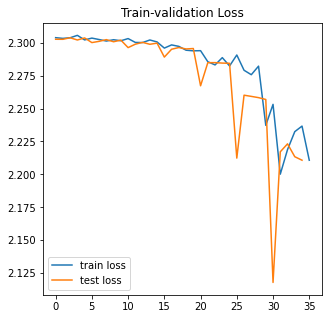

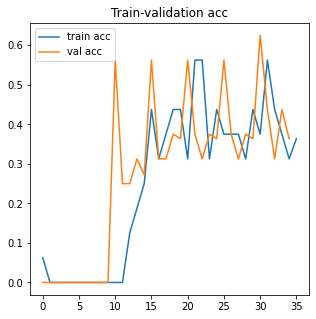

In [61]:
plt.figure(figsize=(5,5))
plt.title('Train-validation Loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='test loss')
plt.legend()
plt.show()


plt.figure(figsize=(5,5))
plt.title('Train-validation acc')
plt.plot(train_acc_list, label='train acc')
plt.plot(val_acc_list, label='val acc')
plt.legend()
plt.show()


In [50]:

def validation(dataloader, device_):
  global model
  predictions_labels = []
  real_labels = []
  total_loss = 0

  for batch in dataloader:
    # label_batch : 실제 label 값
    # true_labels = batch['labels'].to(device) # .numpy().flatten().tolist()
    real_labels += batch['labels'].numpy().flatten().tolist() #for f1-score

    batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}

    with torch.no_grad():
        outputs = gpt2_model(**batch, output_hidden_states=True)
        loss, logits = outputs[:2]
        hidden_state = outputs.hidden_states

        embedded_tokens = hidden_state[0]

        ## 
        lstm_classifier.eval()
        output = lstm_classifier.forward((hidden, cell), embedded_tokens)
        optimizer.zero_grad()
        #loss = loss_func(output, true_labels)
        pred = np.argmax(output.detach().cpu().numpy(),axis=1).flatten()
        predictions_labels += pred.tolist()

  return real_labels, predictions_labels

In [62]:
## print f1-score
real_labels, predictions_labels = validation(test_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(real_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

              precision    recall  f1-score   support

        Rock       0.44      1.00      0.61        33
         Pop       0.00      0.00      0.00        23
       Metal       0.00      0.00      0.00         4
        Jazz       0.00      0.00      0.00         1
        Folk       0.00      0.00      0.00         5
       Indie       0.00      0.00      0.00         6
         R&B       0.00      0.00      0.00         1
     Hip-Hop       0.00      0.00      0.00         1
  Electronic       0.00      0.00      0.00         0
     Country       0.00      0.00      0.00         1

   micro avg       0.44      0.44      0.44        75
   macro avg       0.04      0.10      0.06        75
weighted avg       0.19      0.44      0.27        75



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

# **balanced test data**

In [ ]:
path_test = 'drive/My Drive/NLP/팀플/study/balanced_train_data.csv'
data_balanced = pd.read_csv(path_test)

In [37]:
a_data, data_balanced_test = train_test_split(data_balanced, test_size=0.01, random_state=123)

balanced_data = SongLyrics(data_balanced_test, truncate=True, gpt2_type="gpt2")

print('Dealing with Test...')
balanced_dataloader = DataLoader(balanced_data, batch_size=16, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(balanced_dataloader))

Dealing with Test...
Created `eval_dataloader` with 1047 batches!


In [ ]:
## print final f1-score
real_labels, predictions_labels = validation(balanced_dataloader, device)

# Create and print the evaluation report.
evaluation_report = classification_report(real_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
print(evaluation_report)

# **아래로는 체크한 거**

In [23]:
def count_num(list):
  #labels = ['0', '1', '2','3','4','5','6','7','8','9']
  new_list = []
  for a in range(10):
    new_list.append(list.count(a))
  return new_list

In [51]:
## print f1-score
real_labels, predictions_labels = validation(test_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(real_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)


              precision    recall  f1-score   support

        Rock       0.43      1.00      0.60       325
         Pop       0.00      0.00      0.00       251
       Metal       0.00      0.00      0.00        70
        Jazz       0.00      0.00      0.00        34
        Folk       0.00      0.00      0.00        23
       Indie       0.00      0.00      0.00        24
         R&B       0.00      0.00      0.00         9
     Hip-Hop       0.00      0.00      0.00         3
  Electronic       0.00      0.00      0.00         7
     Country       0.00      0.00      0.00         4

    accuracy                           0.43       750
   macro avg       0.04      0.10      0.06       750
weighted avg       0.19      0.43      0.26       750



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
print(real_labels)
print(predictions_labels)

new_list = count_num(predictions_labels)
print(new_list)

## 4 > 2 > 1
## epoch 5
## hidden [0]
## acc : 5 > 5 > 5 > 5
## predict label = 모조리 0으로 predict
## dataset = 0.01

[4, 1, 0, 0, 0, 3, 1, 1, 5, 1, 2, 0, 4, 8, 0, 1, 2, 1, 1, 0, 4, 3, 0, 9, 1, 2, 0, 1, 0, 3, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 0, 0, 1, 0, 0, 0, 5, 3, 1, 1, 0, 1, 0, 2, 0, 0, 1, 1, 0, 3, 1, 1, 0, 1, 1, 1, 1, 5, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 5, 0, 0, 0, 1, 0, 1, 0, 2, 0, 4, 0, 1, 2, 1, 0, 0, 0, 1, 7, 1, 3, 1, 0, 0, 5, 1, 0, 4, 2, 0, 0, 1, 0, 1, 1, 2, 0, 1, 2, 0, 0, 2, 2, 0, 0, 0, 1, 2, 1, 1, 1, 0, 3, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 5, 0, 1, 0, 3, 0, 1, 0, 1, 0, 1, 0, 1, 3, 2, 1, 2, 0, 0, 0, 1, 0, 0, 3, 1, 1, 2, 0, 0, 0, 5, 0, 1, 6, 3, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 8, 0, 0, 0, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 4, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 5, 2, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 8, 3, 0, 0, 0, 0, 4, 4, 1, 0, 2, 1, 1, 2, 1, 0, 1, 1, 0, 0, 0, 0, 1, 6, 0, 2, 0, 2, 2, 0, 0, 0, 0, 1, 0, 8, 0, 0, 4, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 3, 6, 0, 3, 0, 1, 0, 5, 0, 0, 1, 1, 0, 1, 0, 0, 0, 6, 0, 2, 1, 2, 1, 0, 1, 0, 1, 0, 1, 

In [38]:
## print final f1-score
true_labels, predictions_labels = validation(balanced_dataloader, device)

# Create and print the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
print(evaluation_report)

              precision    recall  f1-score   support

        Rock       0.10      0.92      0.18      1683
         Pop       0.00      0.00      0.00      1683
       Metal       0.00      0.00      0.00      1683
        Jazz       0.00      0.00      0.00      1683
        Folk       0.00      0.00      0.00      1683
       Indie       0.00      0.00      0.00      1683
         R&B       0.00      0.00      0.00      1683
     Hip-Hop       0.00      0.00      0.00      1683
  Electronic       0.10      0.07      0.08      1683
     Country       0.00      0.00      0.00      1594

    accuracy                           0.10     16741
   macro avg       0.02      0.10      0.03     16741
weighted avg       0.02      0.10      0.03     16741



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
print(true_labels)
print(predictions_labels)

new_list = count_num(predictions_labels)
print(new_list)

## 4 > 2 > 4 > 1
## epoch 5
## hidden [0]
## balanced case
## acc : 0 > 0 > 2727 > 3636 > 3636
## predict label = 모조리 0으로 predict
## dataset = 0.001

[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 

In [35]:
## print f1-score
real_labels, predictions_labels = validation(test_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(real_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)



              precision    recall  f1-score   support

        Rock       0.43      0.91      0.58        33
         Pop       0.00      0.00      0.00        23
       Metal       0.00      0.00      0.00         4
        Jazz       0.00      0.00      0.00         1
        Folk       0.00      0.00      0.00         5
       Indie       0.00      0.00      0.00         6
         R&B       0.00      0.00      0.00         1
     Hip-Hop       0.00      0.00      0.00         1
  Electronic       0.00      0.00      0.00         0
     Country       0.00      0.00      0.00         1

    accuracy                           0.40        75
   macro avg       0.04      0.09      0.06        75
weighted avg       0.19      0.40      0.26        75



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [36]:
print(real_labels)
print(predictions_labels)

new_list = count_num(predictions_labels)
print(new_list)

## 4 > 2 > 4 > 1
## epoch 3
## hidden [0]
## acc : 5 > 5 > 5
## predict label = 모조리 0으로 predict
## dataset = 0.001

[0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 5, 0, 0, 0, 1, 0, 1, 0, 0, 4, 3, 1, 0, 0, 2, 1, 1, 2, 2, 6, 0, 7, 2, 0, 5, 1, 1, 0, 1, 0, 1, 9, 0, 1, 0, 1, 0, 1, 0, 5, 0, 5, 4, 4, 0, 5, 0, 4, 0, 1, 1, 4, 0, 1, 0, 1, 1, 5, 0, 1, 0]
[8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[70, 0, 0, 0, 0, 0, 0, 0, 5, 0]
